In [1]:
# import tensorflow

In [2]:
import pandas as pd
# import os


df_sales_train = pd.read_csv("sales1.csv")
df_items = pd.read_csv("final_dataset - items.csv")


df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21840\3092464259.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce')


In [3]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [4]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

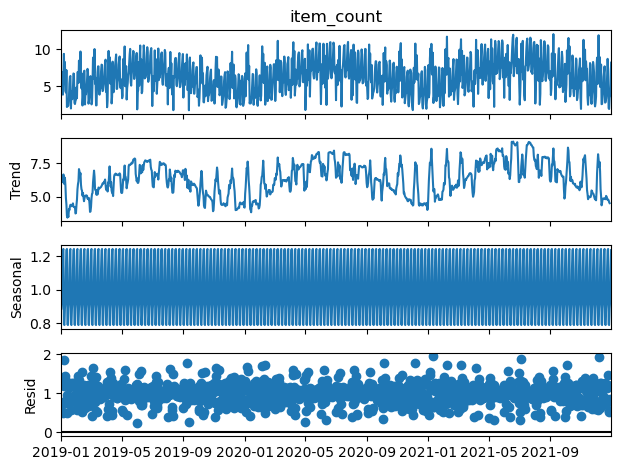

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean()

# extrapolate_trend='freq',
adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative') # , model='additive', period=7

# multiplicative
# additive

adjustment.plot()
pyplot.show()

In [6]:
adjustment.trend

date
2019-01-01         NaN
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    6.095714
2019-01-05    6.664286
                ...   
2021-12-27    4.610000
2021-12-28    4.537143
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: trend, Length: 1096, dtype: float64

In [7]:
adjustment.seasonal

date
2019-01-01    0.886579
2019-01-02    0.929143
2019-01-03    1.123160
2019-01-04    1.235977
2019-01-05    1.242942
                ...   
2021-12-27    0.788570
2021-12-28    0.886579
2021-12-29    0.929143
2021-12-30    1.123160
2021-12-31    1.235977
Name: seasonal, Length: 1096, dtype: float64

In [8]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [9]:
df_adjustment=pd.DataFrame(adjustment.seasonal)
df_adjustment['trend'] = adjustment.trend

df_adjustment

,seasonal,trend
date,,
2019-01-01,0.886579,NaN
2019-01-02,0.929143,NaN
2019-01-03,1.123160,NaN
2019-01-04,1.235977,6.095714
2019-01-05,1.242942,6.664286
...,...,...
2021-12-27,0.788570,4.610000
2021-12-28,0.886579,4.537143
2021-12-29,0.929143,NaN


In [10]:
df_adjustment.to_pickle("adjustment.pkl")

In [11]:
df_sales_adj = df_sales_train.merge(df_adjustment,right_index=True,left_on="date")
df_sales_adj.dropna(inplace=True)
df_sales_adj['adjust'] = df_sales_adj.item_count / df_sales_adj.seasonal / df_sales_adj.trend

In [12]:


SINGLE_YEAR = 2020

df_sales_single_year = df_sales_adj[df_sales_train['date'].dt.year == SINGLE_YEAR]
df_plot = df_sales_single_year[['date','item_id','adjust']].groupby(['date','item_id']).mean().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['date','adjust','name']]
fig = px.bar(df_plot, x='date', y='adjust',color="name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21840\26923303.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [13]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales_adj.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','adjust','store_id','item_count','seasonal','trend']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'adjust':['mean'],'item_count':['mean'],'seasonal':['mean'],'trend':['mean']})
df_train.columns = ['item', 'store', 'date', 'adjust', 'item_count', 'seasonal', 'trend']
df_train.head()

,item,store,date,adjust,item_count,seasonal,trend
0,1,4,2019-01-04,0.0,0.0,1.235977,6.095714
1,1,4,2019-01-05,0.0,0.0,1.242942,6.664286
2,1,4,2019-01-06,0.0,0.0,0.793629,6.347143
3,1,4,2019-01-07,0.0,0.0,0.788570,5.950000
4,1,4,2019-01-08,0.0,0.0,0.886579,6.424286


In [15]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear
df_train

,item,store,date,adjust,item_count,seasonal,trend,dow,doy
0,1,4,2019-01-04,0.0,0.0,1.235977,6.095714,4,4
1,1,4,2019-01-05,0.0,0.0,1.242942,6.664286,5,5
2,1,4,2019-01-06,0.0,0.0,0.793629,6.347143,6,6
3,1,4,2019-01-07,0.0,0.0,0.788570,5.950000,0,7
4,1,4,2019-01-08,0.0,0.0,0.886579,6.424286,1,8
...,...,...,...,...,...,...,...,...,...
108995,100,2,2021-12-24,0.0,0.0,1.235977,4.771429,4,358
108996,100,2,2021-12-25,0.0,0.0,1.242942,4.792857,5,359
108997,100,2,2021-12-26,0.0,0.0,0.793629,4.752857,6,360
108998,100,2,2021-12-27,0.0,0.0,0.788570,4.610000,0,361


In [16]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),adjust(t-29),item_count(t-29),seasonal(t-29),trend(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),...,dow(t),doy(t),item(t+30),store(t+30),adjust(t+30),item_count(t+30),seasonal(t+30),trend(t+30),dow(t+30),doy(t+30)
29,1.0,4.0,0.0,0.0,1.235977,6.095714,4.0,4.0,1.0,4.0,...,5,33,1.0,4.0,0.0,0.0,0.788570,5.288571,0.0,63.0
30,1.0,4.0,0.0,0.0,1.242942,6.664286,5.0,5.0,1.0,4.0,...,6,34,1.0,4.0,0.0,0.0,0.886579,6.081429,1.0,64.0
31,1.0,4.0,0.0,0.0,0.793629,6.347143,6.0,6.0,1.0,4.0,...,0,35,1.0,4.0,0.0,0.0,0.929143,6.480000,2.0,65.0
32,1.0,4.0,0.0,0.0,0.788570,5.950000,0.0,7.0,1.0,4.0,...,1,36,1.0,4.0,0.0,0.0,1.123160,6.948571,3.0,66.0
33,1.0,4.0,0.0,0.0,0.886579,6.424286,1.0,8.0,1.0,4.0,...,2,37,1.0,4.0,0.0,0.0,1.235977,6.505714,4.0,67.0


In [17]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
last_dow = 'dow(t-%d)' % window
last_doy = 'doy(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [18]:
import numpy as np
from keras.utils import to_categorical   

def drop_column(df, col):
  columns_to_drop = [('%s(t+%d)' % (col, future_span))]
  for i in range(window, 0, -1):
      columns_to_drop += [('%s(t-%d)' % (col, i))]
  df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
  df.drop([f"{col}(t)"], axis=1, inplace=True, errors='ignore')

def cat_seq(df, col):
  return to_categorical(df[col].values)

# Label
labels_col = 'adjust(t+%d)' % future_span
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)
series.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series.drop('doy(t+%d)' % future_span, axis=1, inplace=True)

# Adjustment columns
unadjust_sales_col = 'item_count(t+%d)' % future_span
seasonal_col = 'seasonal(t+%d)' % future_span
trend_col = 'trend(t+%d)' % future_span

hold_sales = series[unadjust_sales_col]
hold_seasonal = series[seasonal_col]
hold_trend = series[trend_col]

series.drop(unadjust_sales_col, axis=1, inplace=True)
series.drop(seasonal_col, axis=1, inplace=True)
series.drop(trend_col, axis=1, inplace=True)


# Get sales sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "doy")
sales_series = series2.values

# Day of week as a categorical
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "doy")
drop_column(series2, "adjust")
dow_series = series2.values

# Get item sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "adjust")
doy_series = series2.values

# Day of year
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
x = np.concatenate([t1,t2,t3],axis=2)

In [19]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(106070, 120, 1)
(106070, 120, 1)
(106070, 120, 1)


In [20]:


from sklearn.model_selection import train_test_split

# Split the training data into training and validation
data = np.arange(len(x))
y = labels.values
np.random.shuffle(data)
split_pt = int(len(data) * 0.2)
x_valid = x[data[:split_pt]]
x_train = x[data[split_pt:]]
y_valid = y[data[:split_pt]]
y_train = y[data[split_pt:]]

# Also split the seasonality/trend data
y_train_actual = hold_sales.iloc[data[split_pt:]]
y_valid_actual = hold_sales.iloc[data[:split_pt]]

y_train_seasonal = hold_seasonal.iloc[data[split_pt:]]
y_valid_seasonal = hold_seasonal.iloc[data[:split_pt]]

y_train_trend = hold_trend.iloc[data[split_pt:]]
y_valid_trend = hold_trend.iloc[data[:split_pt]]

# Display results
print('Train set shape', x_train.shape)
print('Validation set shape', x_valid.shape)

Train set shape (84856, 120, 3)
Validation set shape (21214, 120, 3)


In [21]:
print('Train set shape', x_train.shape)
print('Validation set shape', y_valid.shape)

Train set shape (84856, 120, 3)
Validation set shape (21214,)


In [22]:


import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 113, 64)           1600      
                                                                 
 max_pooling1d (MaxPooling1  (None, 56, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 50)                179250    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [40]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(x_train, y_train, callbacks=[monitor],
    validation_data=(x_valid, y_valid), epochs=50, verbose=2)

Epoch 1/50
2652/2652 - 13s - loss: 4.1027 - val_loss: 3.3456 - 13s/epoch - 5ms/step
Epoch 2/50
2652/2652 - 12s - loss: 3.8834 - val_loss: 3.6451 - 12s/epoch - 4ms/step
Epoch 3/50
2652/2652 - 12s - loss: 3.9980 - val_loss: 3.2599 - 12s/epoch - 5ms/step
Epoch 4/50
2652/2652 - 13s - loss: 3.7605 - val_loss: 3.6128 - 13s/epoch - 5ms/step
Epoch 5/50
2652/2652 - 12s - loss: 3.7273 - val_loss: 3.2300 - 12s/epoch - 5ms/step
Epoch 6/50
2652/2652 - 14s - loss: 3.4932 - val_loss: 3.5724 - 14s/epoch - 5ms/step
Epoch 7/50
2652/2652 - 13s - loss: 3.5651 - val_loss: 3.7396 - 13s/epoch - 5ms/step
Epoch 8/50
2652/2652 - 15s - loss: 3.5619 - val_loss: 3.1074 - 15s/epoch - 6ms/step
Epoch 9/50
2652/2652 - 13s - loss: 3.5554 - val_loss: 3.2678 - 13s/epoch - 5ms/step
Epoch 10/50
2652/2652 - 12s - loss: 3.5567 - val_loss: 3.5855 - 12s/epoch - 5ms/step
Epoch 11/50
2652/2652 - 12s - loss: 3.3160 - val_loss: 3.8339 - 12s/epoch - 5ms/step
Epoch 12/50
2652/2652 - 767s - loss: 3.4380 - val_loss: 4.5427 - 767s/epoc

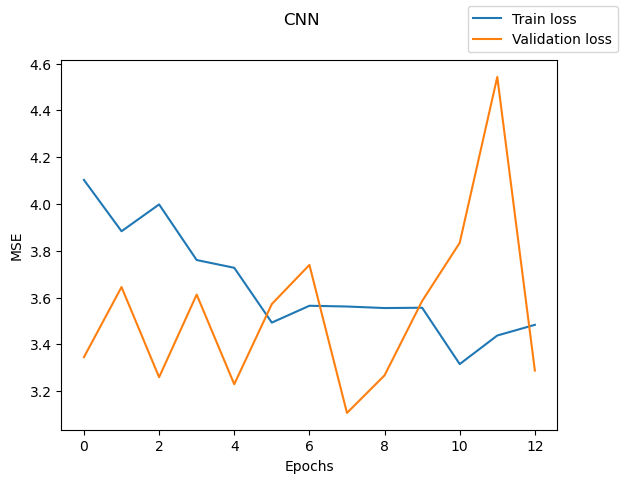

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

In [42]:
from sklearn.metrics import mean_squared_error 
import numpy as np

cnn_train_pred = model.predict(x_train) 
cnn_valid_pred = model.predict(x_valid) 
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred))) 
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_valid_pred)))

663/663 [==============================] - 2s 3ms/step
Train rmse: 1.6490922891273219
Validation rmse: 1.7627721211440248


In [43]:
cnn_train_pred2 = cnn_train_pred.flatten() * y_train_seasonal * y_train_trend
cnn_valid_pred2 = cnn_valid_pred.flatten() * y_valid_seasonal * y_valid_trend

print('Train rmse:', np.sqrt(mean_squared_error(y_train_actual, cnn_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid_actual, cnn_valid_pred2)))

Train rmse: 10.032518430387222
Validation rmse: 10.830953297583664


In [44]:

from sklearn.metrics import r2_score

# Calculate R-squared for the training set
r2_train = r2_score(y_train_actual, cnn_train_pred2)

# Calculate R-squared for the validation set
r2_valid = r2_score(y_valid_actual, cnn_valid_pred2)

# Print the results
print('Train R-squared:', r2_train)
print('Validation R-squared:', r2_valid)


Train R-squared: 0.8874166913626023
Validation R-squared: 0.8792699453482741


In [45]:
import datetime

def forecast_demand(item_id):
    # Assume that df_items is the DataFrame containing item information
    item_info = df_items[df_items['id'] == item_id]

    if item_info.empty:
        print(f"Item with id {item_id} not found.")
        return None

    # Define the window size expected by the model
    window_size = 120

    # Create a sequence for the input item_id, store_id, dow, doy
    input_sequence = np.array([
        [
            item_id,  # item_id
            item_info['store_id'].values[0],  # store_id
            datetime.datetime.now().weekday(),  # current day of week
            datetime.datetime.now().timetuple().tm_yday  # current day of year
        ]
    ])

    # Repeat the sequence to match the window size
    input_sequence = np.repeat(input_sequence, window_size, axis=0)

    # Reshape the input sequence to match the model's input shape
    input_sequence = input_sequence.reshape((1, window_size, 4))  # Adjusted to 4 features

    # Remove the unnecessary fourth feature
    input_sequence = input_sequence[:, :, :3]

    # Make the prediction
    prediction = model.predict(input_sequence)

    if not prediction:
        print("Prediction failed.")
        return None

    # Extract the seasonal and trend components
    seasonal_component = hold_seasonal.iloc[-1]  # Assume the last seasonal component for simplicity
    trend_component = hold_trend.iloc[-1]  # Assume the last trend component for simplicity

    # Adjust the prediction by multiplying with seasonal and trend components
    adjusted_prediction = prediction.flatten() * seasonal_component * trend_component

    return adjusted_prediction[0]

# Example usage:
item_id_to_forecast = 55  # Replace with the desired item_id
forecasted_demand = forecast_demand(item_id_to_forecast)

if forecasted_demand is not None:
    print(f"Forecasted demand for item {item_id_to_forecast}: {forecasted_demand}")
else:
    print("Forecasting failed.")


1/1 [==============================] - 0s 32ms/step
Forecasted demand for item 55: 47.182647705078125


In [47]:
# Function to predict future inventory levels and determine reorder status
def optimize_inventory(model, current_inventory, future_demand_predictions, reorder_threshold=.8):
    future_inventory_predictions = current_inventory - future_demand_predictions
    
    # Determine whether to reorder or not based on reorder_threshold
    reorder_decision = future_inventory_predictions < (reorder_threshold * current_inventory)
    
    return reorder_decision, future_inventory_predictions


# Use the trained model to make predictions on the validation set
cnn_valid_pred = model.predict(x_valid)

# Get current inventory levels (you should replace this with your actual inventory data)
current_inventory = np.array([100] * len(cnn_valid_pred))

# Optimize inventory based on model predictions and current inventory
reorder_decision, future_inventory_predictions = optimize_inventory(model, current_inventory, cnn_valid_pred)

# Display results
print("Reorder Decision:", reorder_decision)
print("Future Inventory Predictions:", future_inventory_predictions)


663/663 [==============================] - 2s 2ms/step
Reorder Decision: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Future Inventory Predictions: [[99.94500881 99.94500881 99.94500881 ... 99.94500881 99.94500881
  99.94500881]
 [91.65869808 91.65869808 91.65869808 ... 91.65869808 91.65869808
  91.65869808]
 [99.41616195 99.41616195 99.41616195 ... 99.41616195 99.41616195
  99.41616195]
 ...
 [99.91670927 99.91670927 99.91670927 ... 99.91670927 99.91670927
  99.91670927]
 [99.94460887 99.94460887 99.94460887 ... 99.94460887 99.94460887
  99.94460887]
 [98.95558369 98.95558369 98.95558369 ... 98.95558369 98.95558369
  98.95558369]]


In [ ]:
# Function to predict future inventory levels and determine reorder status for a specific date
def optimize_inventory_for_date(model, current_inventory, date, reorder_threshold=0.8):
    # Locate the index corresponding to the given date
    date_index = df_train[df_train['date'] == date].index[1]
    
    # Use the trained model to make predictions on the validation set for that specific date
    cnn_valid_pred_for_date = model.predict(x_valid[date_index:date_index+1])

    # Optimize inventory based on model predictions and current inventory for that specific date
    reorder_decision, future_inventory_prediction = optimize_inventory(model, current_inventory, cnn_valid_pred_for_date)

    return reorder_decision[0], future_inventory_prediction[0]

# Example: Specify a date for which you want to check the reorder decision
example_date = pd.to_datetime('2019-01-04')

# Get the current inventory level for the example date (replace with your actual inventory data)
example_current_inventory = 100

# Call the function to get the reorder decision and future inventory prediction for the example date
reorder_decision_for_date, future_inventory_for_date = optimize_inventory_for_date(model, example_current_inventory, example_date)

# Display results for the example date
print(f"For {example_date}:")
print("Reorder Decision:", reorder_decision_for_date)
print("Future Inventory Prediction:", future_inventory_for_date)


1/1 [==============================] - 0s 27ms/step
For 2019-01-04 00:00:00:
Reorder Decision: [False]
Future Inventory Prediction: [99.86141]


In [48]:
model.save("final_inventory.h5")

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [49]:
import pickle

In [50]:
with open('OptimizeInventory_pickle','wb') as f:
    pickle.dump(model,f)

In [51]:
with open('OptimizeInventory_pickle','rb') as f:
    mp=pickle.load(f)